### IEM6990 Block-SONATA Project Code

#### Jayesh Yevale, Yuxuan Li

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from math import *
import random 
from numpy import linalg as LA
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
mnist = fetch_openml('mnist_784', version=1)
U0, v0 = mnist["data"], mnist["target"]
U= U0.astype(np.double)
v = v0.astype(np.uint8)

In [9]:
v_bin_5_lst = [2*int(v[i]==5)-1 for i in range(len(v))]

In [10]:
df_U = pd.DataFrame(data=U)
df_v = pd.DataFrame(data=np.asarray(v_bin_5_lst),  columns=['label'])
df_data_merged =pd.concat([df_U, df_v.reindex(df_U.index)], axis=1)
df_data_merged.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [11]:
n_attributes = 100
n_labels = 11000
np.random.seed(1)
mu, sigma = 0, 1
rnd_data = np.random.normal(mu, sigma, size=[n_labels, n_attributes])

df_rnd_data = pd.DataFrame(data=rnd_data )
df_rnd_labels = pd.DataFrame(data=np.asarray(v_bin_5_lst),  columns=['label'])
df_data_merged_rnd =pd.concat([df_rnd_data, df_rnd_labels.reindex(df_rnd_data.index)], axis=1)
df_data_merged_rnd.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,...,0.185156,-0.375285,-0.638730,0.423494,0.077340,-0.343854,0.043597,-0.620001,0.698032,1
1,-0.447129,1.224508,0.403492,0.593579,-1.094912,0.169382,0.740556,-0.953701,-0.266219,0.032615,...,0.369493,1.904659,1.111057,0.659050,-1.627438,0.602319,0.420282,0.810952,1.044442,-1
2,-0.400878,0.824006,-0.562305,1.954878,-1.331952,-1.760689,-1.650721,-0.890556,-1.119115,1.956079,...,-0.056824,0.492337,-0.680678,-0.084508,-0.297362,0.417302,0.784771,-0.955425,0.585910,-1
3,2.065783,-1.471157,-0.830172,-0.880578,-0.279098,1.622849,0.013353,-0.694694,0.621804,-0.599805,...,1.767960,-0.475373,0.477610,-1.021886,0.794528,-1.873161,0.920615,-0.035368,2.110605,-1
4,-1.306534,0.076380,0.367232,1.232899,-0.422857,0.086464,-2.142467,-0.830169,0.451616,1.104174,...,0.630196,-0.414847,0.451946,-1.579156,-0.828628,0.528880,-2.237087,-1.107713,-0.017718,-1


In [12]:
def split_train_test(df_data_merged, train_set_size,test_set_size,m):
    np.random.seed(0)
    shuffled_indices = np.random.permutation(len(df_data_merged))
    batch_size = int(train_set_size/m)
    dic_train_sets_indices= {}
    dic_train_sets = {}
    for i in range(m):
        dic_train_sets_indices[i] = shuffled_indices[i*batch_size:(i+1)*batch_size]
        dic_train_sets[i] = df_data_merged.iloc[dic_train_sets_indices[i]]
    dic_train_set = {}
    dic_train_set_indices = shuffled_indices[:m*batch_size]
    dic_train_set[0] = df_data_merged.iloc[dic_train_set_indices]
    dic_test_set= {}
    test_indices = shuffled_indices[-test_set_size:]
    dic_test_set[0] = df_data_merged.iloc[test_indices]
    return dic_train_set, dic_train_sets, dic_test_set

In [13]:
def R_matrix(graph_name,m): # Graph function
    output = np.zeros((m,m))
    if m==1:
        output =np.array([[1]])
    elif graph_name == "star":
        for i in range(m):
            output[i,i]+=0.5
            output[i,0]+=0.5
    elif graph_name == "ring":
        for i in range(m):
            output[i,i]=0.5
            output[np.remainder(i+1,m) ,i]=0.5
    elif graph_name == "line":
        for i in range(m-1):
            output[i,i]=0.5
            output[i+1 ,i]=0.5
        output[0,0]=1
        output[m-1,m-1]=0.5
        output[2,1]=0
        output[2,2]=1
    elif graph_name == "complete":
        output = np.ones((m,m))/(2*(m-1))
        for i in range(m):
            output[i,i]=0.5
        #output = np.ones((m,m))/m 
    else:
        print("The graph name is unknown!")
    return output

In [14]:
def f_obj_global(x,dic_train,mu_param,m):
    output = sum([f_obj_local(x[i,:],dic_train[i],mu_param,m) for i in range(m)])
    return output

def f_obj_local(y,df_data,mu_param,m):
    npar_data= (df_data).to_numpy()
    nparr_data_transp = npar_data.T
    data = nparr_data_transp[:-1,:]
    labels =nparr_data_transp[-1:,:]
    n_attributes,n_labels = np.shape(data)
    x=y.reshape((n_attributes,1))
    v1 = np.dot(data.T,x) 
    v2 = -np.multiply(labels.T,v1)
    obj_val = 0
    obj_val = sum([v2[i,0] if v2[i,0] > 709 else np.log(1+np.exp(v2[i,0])) for i in range(n_labels)])
    output = obj_val + mu_param*np.dot(x.T,x)/2
    return output

#### Gradient required for argmin function and updating

In [15]:
# Used for computing the \tilda{x} in Local Optimization
def argmin(data_new,labels,iteration,step_size,grad,agents,up,low):
    n_attributes,n_labels = np.shape(data_new)
    initial_x = np.zeros((n_attributes,1))
    x_now_GDM = initial_x.T
    x_next_GDM = initial_x.T
    # It is hard to find the real argmin value so we use GD to approach it.
    for t in range(iteration+1):
        x_now_GDM = x_next_GDM
        output = sum(-((labels[0,t]*data_new[:,t])**2).T*np.exp(min(709,labels[0,t]*np.dot(x_now_GDM,data_new[:,t])))*(1/(1+np.exp(min(709,labels[0,t]*np.dot(x_now_GDM,data_new[:,t]))))**2) for t in range(n_labels))        
        x_next_GDM = x_now_GDM - step_size*(np.expand_dims(agents*grad, axis = 0)-np.expand_dims(output,axis=0)/n_labels)
    return x_next_GDM

# Local Optimization update - updating and sending the \delta{x} to Main Algorithm
def del_x(i,j,x,data,labels,grad, agents, pass_value, mu_param,up,low):
    p = int(str(j).replace("[","").replace("]",""))
    if pass_value == False:
        if i == p: 
            delta_x = np.zeros([x.shape[0]])
        else:
            argmin_x = argmin(data[up:low,:],labels,5,0.001,grad,agents,up,low)
            x_tilda = argmin_x + mu_param*np.dot(argmin_x,argmin_x.T)
            delta_x = x_tilda - x            
    else:
        argmin_x = argmin(data[up:low,:],labels,5,0.001,grad,agents,up,low)
        x_tilda = argmin_x + mu_param*np.dot(argmin_x,argmin_x.T)
        delta_x = x_tilda - x   
    return delta_x

In [16]:
def gradient(x,data,labels): # computing gradient for the algorithm
    n_attributes,n_labels = np.shape(data)
    output = sum(-(labels[0,i]/(1+np.exp(min(709,labels[0,i]*np.dot(data[:,i],x)))))*data[:,[i]] 
                for i in range(n_labels))/n_labels
    return output

# Computing Auxilary variable - Modified update
def grad_func(grad_block,l,li,x,up,low,data,labels): # Selecting the required block from gradient update and 
    if (l==li):
        g_next = gradient(x,data,labels)
    else:
        g_next = grad_block
    return g_next

In [25]:
# Decide the N_i for each i
def graph_connection(i, A_matrix):
    return (np.argwhere(A_matrix[i,:] != 0)).tolist()

# Decide the N_{i,l}^t for each i
def graph_passing(i, agents, l, l_agent, l_agent_new, Ni):
    if len(np.argwhere(l_agent_new == l)) != 0:
        nilt = [item for item in Ni if item  in (np.argwhere(l_agent_new == l)).tolist()]
        pass_value = True
    else:
        nilt = list([i])
        pass_value = False
    if nilt == []:
        nilt = list([i])
    return nilt, pass_value

# Computing a_{i,j,l} from A_matrix
def func_a(i, j, A_matrix, pass_value):
    p = int(str(j).replace("[","").replace("]",""))
    if pass_value == False:
        if p == i:    
            a = 1
        else:
            a = A_matrix[i,p]
    else:
        a = A_matrix[i,p]
    return a

# Obtaining the data and labels values for each agent - simplification step
def getdata(dic):
    df= dic
    dataset= (df).to_numpy()
    data_new = dataset.T
    data = data_new[:-1,:]
    labels =data_new[-1:,:]
    return data,labels

#### Main function

In [26]:
def block_sonata(dic_train_sets, mu_param, attributes, gamma, blocks, agents, max_iter, A_matrix):
    # Given that it is a nonconvex problem in the paper, we use the regularized logistic regression algorithm here for convex case.
    df = dic_train_sets[0]
    dataset= (df).to_numpy()
    data_new = dataset.T
    data = data_new[:-1,:]
    labels =data_new[-1:,:]
    attributes,labels = data.shape # obtaining attributes
    
    # Initialization
    phi_now = np.ones([agents,blocks])
    phi_next = np.ones([agents,blocks])
    x_now = np.ones([agents,attributes])
    x_next = np.ones([agents,attributes])
    y_now = np.ones([agents,attributes])
    y_next = np.ones([agents,attributes])
    grad_now = np.ones([agents,attributes])
    for i in range(agents): # Initializing gradient values to grad_now
        data,labels = getdata(dic_train_sets[i])
        grad_now[i,:] = gradient(x_now[i,:],data,labels).transpose()
    grad_next = np.ones([agents,attributes])
    length = int(attributes/blocks) # storing length of each block
    # for storing random block values for all agents at given iteration
    l_agent_new = np.array([random.randint(0,blocks-1) for _ in range(agents)]) 
    f_values = np.zeros(epoch_size+1) # Objective function values
    epoch_index = 0
    
    for k in range(max_iter):
        l_agent = l_agent_new
        l_agent_new = np.array([random.randint(0,blocks-1) for _ in range(agents)]) # random block allocation
        gamma_new = gamma ** (k+1)
        
        for i in range(agents):
            Ni = graph_connection(i, A_matrix) # obtaining connected agents information
            data,labels = getdata(dic_train_sets[i])
            
            for l in range(blocks):
                Nilt, pass_value = graph_passing(i, agents, l, l_agent, l_agent_new, Ni) # obtaining N(i,l,t)
                up=l*length # block range begin
                low=(l+1)*length # block range end
                
                x_now_block = x_now[i,up:low]
                grad_now_block = grad_now[i,up:low]
                phi_next[i,l] = sum(func_a(i, j, A_matrix, pass_value)*phi_now[j,l] for j in Nilt) # Update phi
                x_next_block = sum((func_a(i, j, A_matrix, pass_value)*phi_now[j,l]*
                                    (x_now[j,up:low]+gamma_new*del_x(i,j,x_now_block,data,labels,grad_now_block, agents, pass_value, mu_param,up,low)))
                                    for j in Nilt)/phi_next[i,l]      # Update x_next_block    
                                   
                grad_now_block = np.expand_dims(grad_now[i,up:low],axis=0)
                grad_next_block = grad_func(grad_now[i,up:low],l,l_agent[i],x_now[i,up:low],up,low,data[up:low,:],labels).transpose() # Updating g_next_block 
                
                y_next_block = sum((func_a(i, j, A_matrix, pass_value)) 
                                   *(phi_now[j,l]*y_now[j,up:low]) for j in Nilt)/phi_next[i,l]+((grad_next_block-grad_now_block)/phi_next[i,l]) # Update y_next_block
                
                # Updating block in original next matrix
                x_next[i,up:low] = x_next_block
                y_next[i,up:low] = y_next_block
                grad_next[i,up:low] = grad_next_block
        
        # updating now matrix to next matrix for recursion   
        x_now=x_next      
        y_now=y_next
        phi_now=phi_next     
        grad_now=grad_next
        
        #Objective function
        if max_iter==0 or (k % np.ceil(max_iter/epoch_size)) == 0:    
            f_values[epoch_index] = f_obj_global(x_now,dic_train_sets,mu_param,agents)
            epoch_index += 1
        
    return x_now,f_values

In [27]:
train_set_size, test_set_size, m = 10000, 1000, 10
dic_train_set, dic_train_sets, dic_test_set = split_train_test(df_data_merged_rnd, train_set_size, test_set_size, m)
df = dic_train_sets[0]
dataset= (df).to_numpy()
data_new = dataset.T
data = data_new[:-1,:]
labels =data_new[-1:,:]
A_matrix = R_matrix("ring",10)
print(A_matrix)

[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]


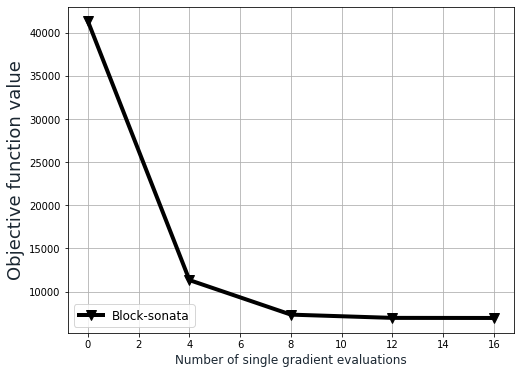

In [40]:
attributes = len(dic_train_set[0].columns)-1
labels = len(dic_train_set[0])
mu_param = 10**(-2)
epoch_size = 5
# Given that the computational cost is high, we just set iterations as 20.
max_iter = 20
step_size = 0.3
gamma = 0.001
blocks = 10
agents = 10

X_sol_BS,f_vals_BS = block_sonata(dic_train_sets, mu_param, attributes, gamma, blocks, agents, max_iter, A_matrix)
    
fig = plt.figure(figsize=(8,6))

plt.plot(range(0,max_iter,np.int(max_iter/epoch_size)),f_vals_BS.tolist()[0:5],color='black',
         marker='v',markersize=10,linestyle='solid',label="Block-sonata",linewidth=4)

plt.legend(loc=3,fontsize=12)
plt.xlabel('Number of single gradient evaluations', color='#1C2833',fontsize=12)
plt.ylabel("Objective function value", color='#1C2833',fontsize=18)


plt.grid(True)

In [47]:
df_x = pd.DataFrame(data=X_sol_BS )
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,...,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122
1,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,...,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122
2,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,0.000406,...,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061
3,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,...,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061
4,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,0.000244,...,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061


In [50]:
def my_confu_mat(dic_test_set,opt_sol):
    npar_data= (dic_test_set[0]).to_numpy()
    test_data = npar_data[:,:-1]
    test_labels =npar_data[:,-1:]
    test_set_size = len(dic_test_set[0])
    pred_labels = np.zeros((test_set_size,1))
    for j in range(test_set_size):
        pred_labels[j][0] = np.sign(np.dot(test_data[j,:],opt_sol))
    output = confusion_matrix(test_labels, pred_labels)
    return output

def precision_score(dic_test_set,opt_sol):
    confu_mat = my_confu_mat(dic_test_set,opt_sol)
    output = confu_mat[1][1]/(confu_mat[1][0]+confu_mat[1][1])
    return output

confu_mat = my_confu_mat(dic_test_set,X_sol_BS[0,:])
print("Confusion matrix:\n",confu_mat)

bs_precision = confu_mat[1][1]/(confu_mat[1][0]+confu_mat[1][1])
print("block_sonata precision metric: ", "{0:.0%}".format(bs_precision))

Confusion matrix:
 [[439 473]
 [ 52  36]]
block_sonata precision metric:  41%
